# Predict Pokemon type by its image

## Parameters

In [1]:
from pathlib import Path

# Directory of the csv 
BASE_DIR = Path('/Users/efraflores/Desktop/EF/Diplo/data/04/pokemon')
# Images directory
IMAGES_DIR = BASE_DIR.joinpath('images')
# Csv file name
FILE_NAME = 'pokemon.csv'
# Column name indicating the image path
PATH_COL = 'filename'
# f(X) = y <-- result column
LABEL_COL = 'class'

## Functions

### Timing and tone

In [2]:
import time
import numpy as np
from IPython.lib.display import Audio

start = time.time()
def time_exp(x):
    #Just print how many minutes and seconds have passed
    minutes, seconds = np.floor(x/60), 60*(x/60-np.floor(x/60))
    print(f"{'{:.0f}'.format(minutes)} minutos con {'{:.2f}'.format(seconds)} segundos")
    
def tone(a=1000, b=700, play_time_seconds=1, framerate=4410):
    #Make a sound! Useful while training models
    t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)*np.pi
    return Audio(np.sin(a*t)+np.sin(b*t), rate=framerate, autoplay=True)

### Show pokemon from DataFrame

In [3]:
from PIL import Image

def show_pokemon(pokemon='pikachu', filepath='images', ext='png'):
    img = Image.open(Path(filepath).joinpath(f'{pokemon}.{ext}'))
    return img

### Blur image

In [4]:
#!pip install opencv-python
import cv2
def blur(img):
    blurred = cv2.GaussianBlur(np.asarray(img), ksize=(7, 7), sigmaX=0)
    return blurred

### ImageDataGenerator from DataFrame

In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def images_from_df(data, seed=22, **kwargs):
    
    df = data.copy()
    X_train, X_test = train_test_split(df, train_size=0.77, random_state=seed)

    train_gen = ImageDataGenerator(
                                rescale=1./255,
                                preprocessing_function=blur,
                                shear_range=0.1,
                                zoom_range=0.1,
                                horizontal_flip=True,
                                rotation_range=15
                                )

    training_set = train_gen.flow_from_dataframe(dataframe=X_train, **kwargs)
    testing_set = ImageDataGenerator(rescale=1./255).flow_from_dataframe(dataframe=X_test, **kwargs)
    
    print('\n These are the classes:\n',training_set.class_indices)
    return training_set, testing_set

### CNN builder

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, AveragePooling2D, Dropout, LeakyReLU, BatchNormalization

def cnn_builder(train_set, layer_filters, cnn_activ, layer_units, seq_activ):
    n_classes = len(train_set.class_indices)

    model = Sequential()
    model.add(Conv2D(filters=n_classes*10, kernel_size=2, input_shape=train_set.image_shape, activation=LeakyReLU()))
    model.add(BatchNormalization())
    model.add(MaxPool2D(3))
    for filters,activ in zip(layer_filters, cnn_activ):
        model.add(Conv2D(filters, 3, activation=activ))
        model.add(BatchNormalization())
        model.add(AveragePooling2D(3))
    
    model.add(Dropout(0.1))
    model.add(Flatten())
    
    for units,activa in zip(layer_units, seq_activ):
        model.add(Dense(units, activa))
    
    last_layer,last_activ = (1,'sigmoid') if n_classes<=2 else (n_classes,'softmax')
    model.add(Dense(last_layer, last_activ))
    
    print(model.summary())
    return model

### Plot metrics

In [7]:
import matplotlib.pyplot as plt

def plot_metrics(training_history,metrics=['accuracy','loss']):
    #Show the trend of every metrics provided after training
    for metric in metrics:
        trend = training_history.history[metric]
        plt.figure()
        plt.plot(range(len(trend)), trend, 'r', label=f'Training {metric}')
        plt.title(f'Training {metric}')
    plt.show()

### Confussion Matrix CNN

In [8]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_keras(test_gen, fit_model):
    y_real = test_gen.classes
    y_predicted = [np.argmax(x).reshape(-1,)[0] for x in fit_model.predict(test_gen)]

    cm = pd.DataFrame(confusion_matrix(y_true=y_real, y_pred=y_predicted),
                    index=test_gen.class_indices,
                    columns=test_gen.class_indices)
    print('Accuracy de {:.2%}'.format(np.asarray(cm).trace()/len(y_real)))
     
    size = int(len(test_gen.class_indices)/2)
    fig, ax = plt.subplots(figsize=(size,size))
    sns.heatmap(pd.DataFrame([cm[col]/cm.sum(axis=1) for col in cm.columns],
                            index=test_gen.class_indices,
                            columns=test_gen.class_indices).T.replace({0:np.nan}), 
                annot = True,
                fmt = '.0%',
                cmap = 'Blues',
                linewidths = 0.5, 
                ax = ax)
    plt.show()
    return cm

## Data Wrangling

### Import

In [9]:
import pandas as pd

# Importar csv como DataFrame
df = pd.read_csv(BASE_DIR.joinpath(FILE_NAME))
df.sample()

,Name,Type1,Type2
771,type-null,Normal,NaN


### All images in .jpg

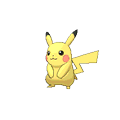

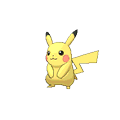

In [10]:
png = show_pokemon(filepath=IMAGES_DIR).convert('RGBA')
png.load()
jpg = Image.new("RGB", png.size, (255, 255, 255))
jpg.paste(png, mask=png.split()[3])
display(png, jpg)

In [11]:
import shutil

BASE_DIR.joinpath('images_correct').mkdir(exist_ok=True)
for x in df['Name']:
    if IMAGES_DIR.joinpath(f'{x}.jpg').exists():
        shutil.copy(IMAGES_DIR.joinpath(f'{x}.jpg'),BASE_DIR.joinpath('images_correct',f'{x}.jpg'))
    else:
        png = Image.open(IMAGES_DIR.joinpath(f'{x}.png')).convert('RGBA')
        png.load()
        background = Image.new("RGB", png.size, (255, 255, 255))
        background.paste(png, mask=png.split()[3])
        background.save(BASE_DIR.joinpath('images_correct',f'{x}.jpg'), 'JPEG', quality=100)
IMAGES_DIR = BASE_DIR.joinpath('images_correct')

### Filename column

In [12]:
# Crear la columna, hay archivos png y jpg
df[PATH_COL] = df['Name'].apply(lambda x: f'{x}.jpg')
df.set_index('Name', inplace=True)
df.sample()

,Type1,Type2,filename
Name,,,
purugly,Normal,NaN,purugly.jpg


### Just one column-label

In [13]:
# Si tiene dos tipos, se agrega otro renglón con el segundo tipo
df = df.melt(id_vars=PATH_COL, value_vars=['Type1','Type2'], ignore_index=False)
# Se ajustan columnas
df = df.rename({'value':LABEL_COL}, axis=1).drop('variable', 1).dropna()
df.sample()

,filename,class
Name,,
spiritomb,spiritomb.jpg,Ghost


In [14]:
# df = df[['filename','Type1']].rename({'Type1':'class'}, axis=1)
# df.sample()

### Image Data Generator

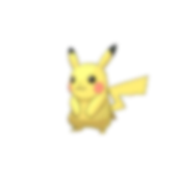

In [15]:
Image.fromarray(blur(jpg)).resize((180,180))

In [16]:
train, test = images_from_df(df, directory=IMAGES_DIR, target_size=(180,180), seed=111)

Found 934 validated image filenames belonging to 18 classes.
Found 280 validated image filenames belonging to 18 classes.

 These are the classes:
 {'Bug': 0, 'Dark': 1, 'Dragon': 2, 'Electric': 3, 'Fairy': 4, 'Fighting': 5, 'Fire': 6, 'Flying': 7, 'Ghost': 8, 'Grass': 9, 'Ground': 10, 'Ice': 11, 'Normal': 12, 'Poison': 13, 'Psychic': 14, 'Rock': 15, 'Steel': 16, 'Water': 17}


## Model

### Arquitecture

In [17]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [18]:
model = cnn_builder(train,[],[],[64],['relu'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 179, 179, 180)     2340      
_________________________________________________________________
batch_normalization (BatchNo (None, 179, 179, 180)     720       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 180)       0         
_________________________________________________________________
dropout (Dropout)            (None, 59, 59, 180)       0         
_________________________________________________________________
flatten (Flatten)            (None, 626580)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                40101184  
_________________________________________________________________
dense_1 (Dense)              (None, 18)                1

### Compile

In [19]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=1e-6)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics='accuracy')

### Callbacks

#### Early Stopping

In [20]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=199)

#### Checkpoints

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(BASE_DIR.joinpath('models/pokemodel_{val_accuracy:.3f}.h5'),
                            save_best_only=True,
                            save_weights_only=False,
                            monitor='val_accuracy')

### Training

#### Fit

In [22]:
train_history = model.fit(train, validation_data=test, epochs=60, callbacks=[early_stopping, checkpoint])

Epoch 1/60
30/30 [==============================] - 71s 2s/step - loss: 2.9416 - accuracy: 0.0803 - val_loss: 2.8583 - val_accuracy: 0.0536
Epoch 2/60
30/30 [==============================] - 70s 2s/step - loss: 2.7853 - accuracy: 0.1413 - val_loss: 2.8478 - val_accuracy: 0.1393
Epoch 3/60
30/30 [==============================] - 70s 2s/step - loss: 2.7459 - accuracy: 0.1467 - val_loss: 2.8489 - val_accuracy: 0.0893
Epoch 4/60
30/30 [==============================] - 69s 2s/step - loss: 2.7189 - accuracy: 0.1660 - val_loss: 2.8463 - val_accuracy: 0.1143
Epoch 5/60
30/30 [==============================] - 68s 2s/step - loss: 2.6737 - accuracy: 0.1756 - val_loss: 2.8435 - val_accuracy: 0.1143
Epoch 6/60
30/30 [==============================] - 69s 2s/step - loss: 2.6455 - accuracy: 0.1799 - val_loss: 2.8384 - val_accuracy: 0.1321
Epoch 7/60
30/30 [==============================] - 69s 2s/step - loss: 2.6048 - accuracy: 0.1959 - val_loss: 2.8316 - val_accuracy: 0.1321
Epoch 8/60
30/30 [==

#### Metrics

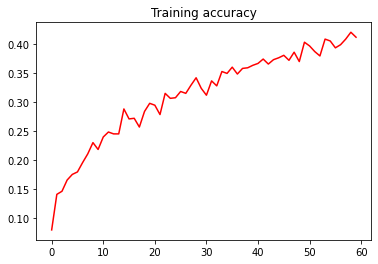

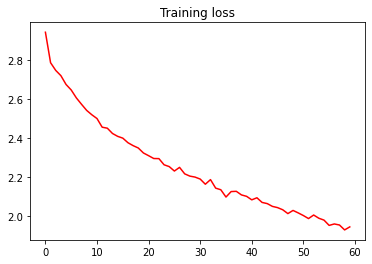

In [23]:
plot_metrics(train_history)

### Export

In [24]:
import pickle

with open(BASE_DIR.joinpath('pokemon_indices.pkl'), 'wb') as f:
    pickle.dump(train.class_indices, f)

In [25]:
import re
from keras.models import load_model

max_acc = max([str(x)[-8:-3] for x in BASE_DIR.joinpath('models').glob('**/*') if x.is_file() and str(x)[-8:]!='DS_Store'])
path_model = [x for x in BASE_DIR.joinpath('models').glob('**/*') if re.search(max_acc,str(x))!=None][0]
print(str(path_model))
best_model = load_model(path_model)

/Users/efraflores/Desktop/EF/Diplo/data/04/pokemon/models/pokemodel_0.200.h5


In [26]:
best_model.save(BASE_DIR.joinpath('pokemon_model.h5'))

## Test

Accuracy de 7.60%


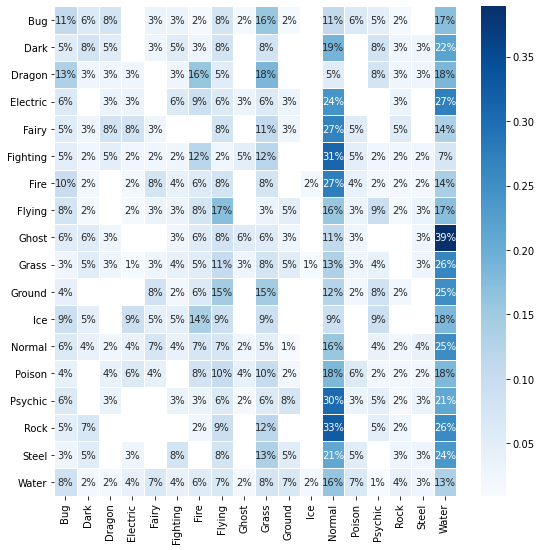

In [27]:
keras_cm_train_model = cm_keras(train,model)

Accuracy de 8.21%


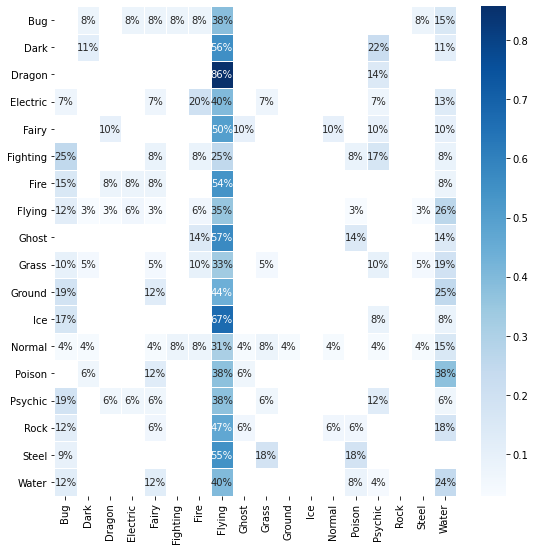

In [28]:
keras_cm_last_model = cm_keras(test,model)

## End

In [31]:
time_exp(time.time() - start)
tone()

71 minutos con 59.57 segundos
